# 1. 결정트리

## 1. 데이터셋 불러오기 및 전처리

화이트와인(클래스:1) 레드와인(클래스:2) 구분하는 과제
https://itstory1592.tistory.com/13


In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [2]:
wine.info()

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:
# 비교를 위한 로지스틱 회귀
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))
print(lr.coef_, lr.intercept_)

0.7808350971714451
0.7776923076923077
[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


가중치 순서: 알코올, 당도, ph

가중치 분석 결과 알코올과 당도가 클수록 양성 클래스(화이트 와인)일 가능성이 높아지고, ph가 클 수록 음성 클래스(레드 와인)을 가능성이 높다.

## 문제1
결정 트리는 로지스틱 회귀와 달리 데이터 scaling 과정이 필요 없다. 그 이유를 작성해주세요

답: 결정 트리는 데이터의 절대적인 크기보다 순서와 분기 기준이 중요하기 때문에 Scaling이 필요 없는 반면 로지스틱 회귀는 데이터 크기가 가중치에 영향을 주는 거리 기반 모델이므로 Scaling이 필요하다.

In [5]:
# 결정 트리
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))


0.996921300750433
0.8592307692307692


## 2. 결정트리 그래프로 확인
로지스틱 회귀 점수에 비해 결정트리에서 매우 높은 점수가 나타났다. 과대적합이 의심된다

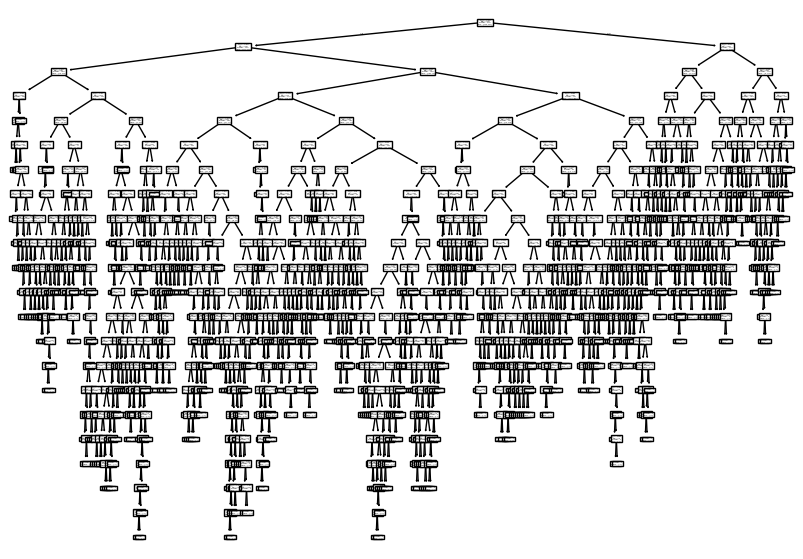

In [6]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

## 3. 가지치기 pruning
가지치기를 사용하여 오버피팅된 결정트리를 최적화하기




## 문제 2 코드를 완성하세요

In [7]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
#깊이를 조정하는 방법
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


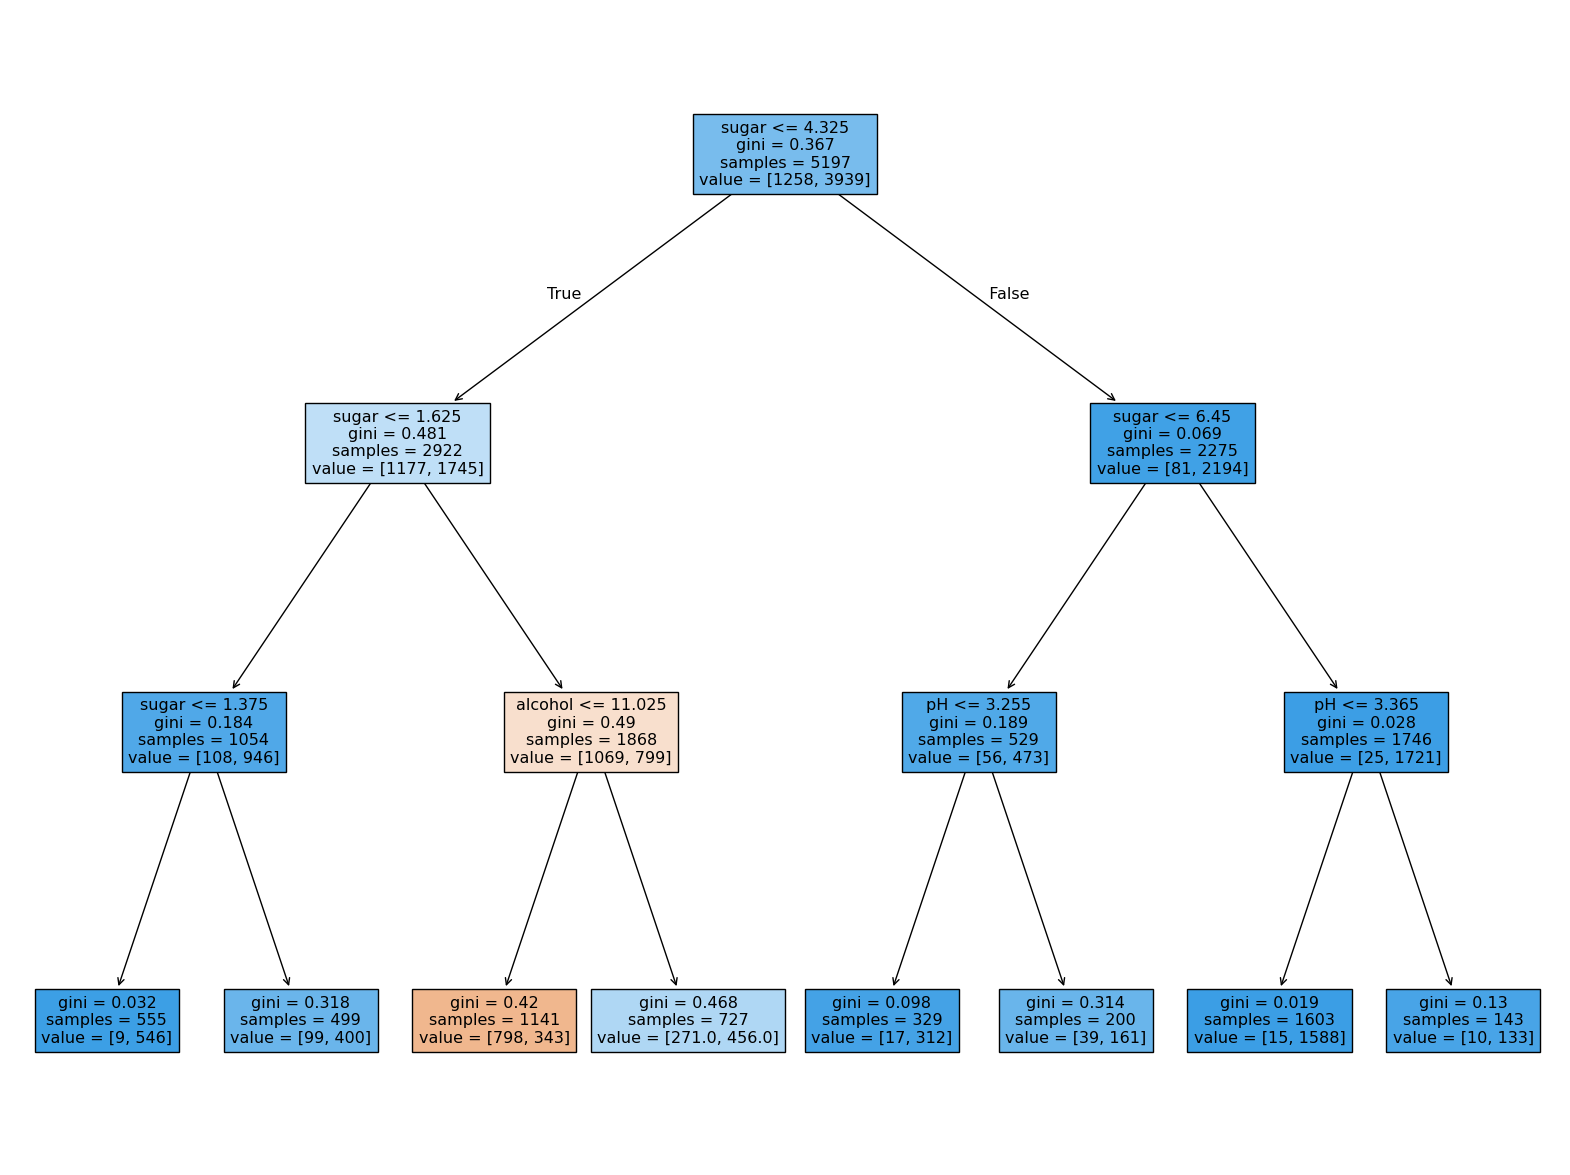

In [8]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [9]:
# 특성 중요도
print('  alcohol      sugar       pH')
print(dt.feature_importances_)

  alcohol      sugar       pH
[0.12345626 0.86862934 0.0079144 ]


In [10]:
#하이퍼파라미터 값을 위한 그리드 서치

from sklearn.model_selection import GridSearchCV
import numpy as np

params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

# min_impurity_decrease : 최소 불순도
# min_impurity_split : 나무 성장을 멈추기 위한 임계치
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

print(gs.best_params_)

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}
0.8615384615384616


# 2. SVM

암 진단이 양성인지 악성인지 여러 관찰/특징에 기초하여 예측한다.
30가지 기능이 사용되며, 예:
- 반지름(둘레의 중심에서 점까지의 거리 mean)
- 텍스처(회색 스케일 값의 표준 편차)
- 둘레의면적
- 평활도(반지름 길이의 국부적 변화)
- 콤팩트성 (perimeter^2 / 면적 - 1.0)
- 오목한 부분(윤곽의 오목한 부분의 severity)
- 오목한 점(윤곽의 오목한 부분의 수)
- 대칭성
- 프랙탈 차원("coastline 근사" - 1)

대상 클래스: 악성, 양성


## 1. 데이터 불러오기

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

cancer=load_breast_cancer()
df_cancer=pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns= np.append(cancer['feature_names'], ['target']))
df_cancer.head()



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


## 2. 데이터 시각화

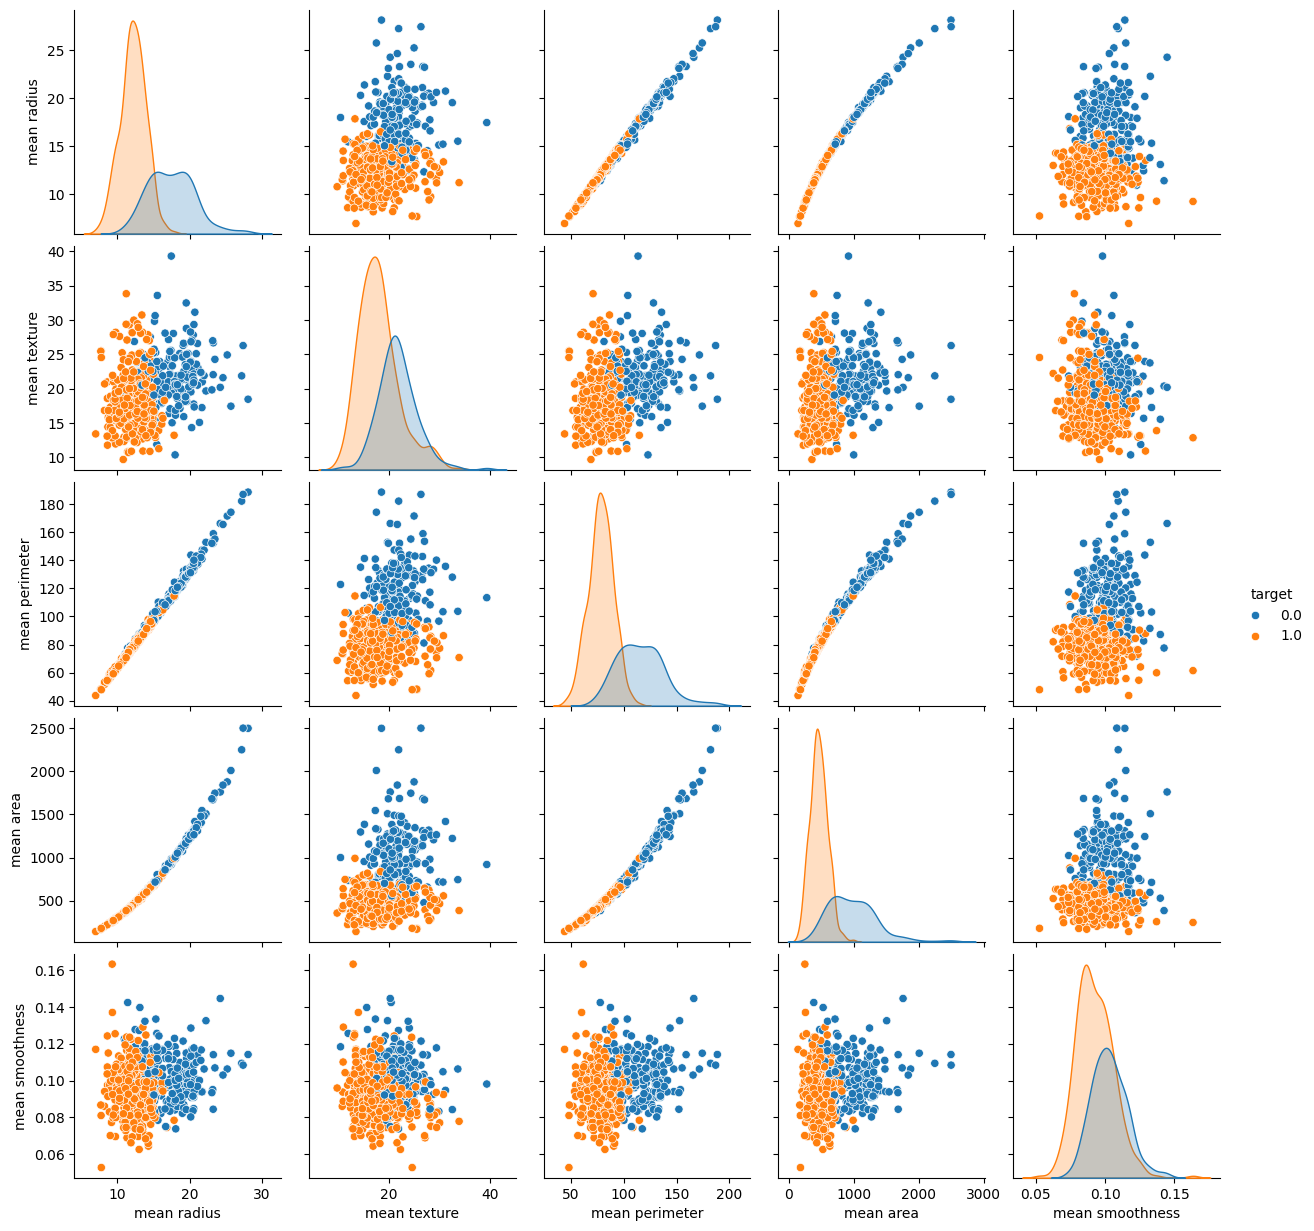

In [12]:
sns.pairplot(df_cancer, hue = 'target', vars = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'])

<Axes: >

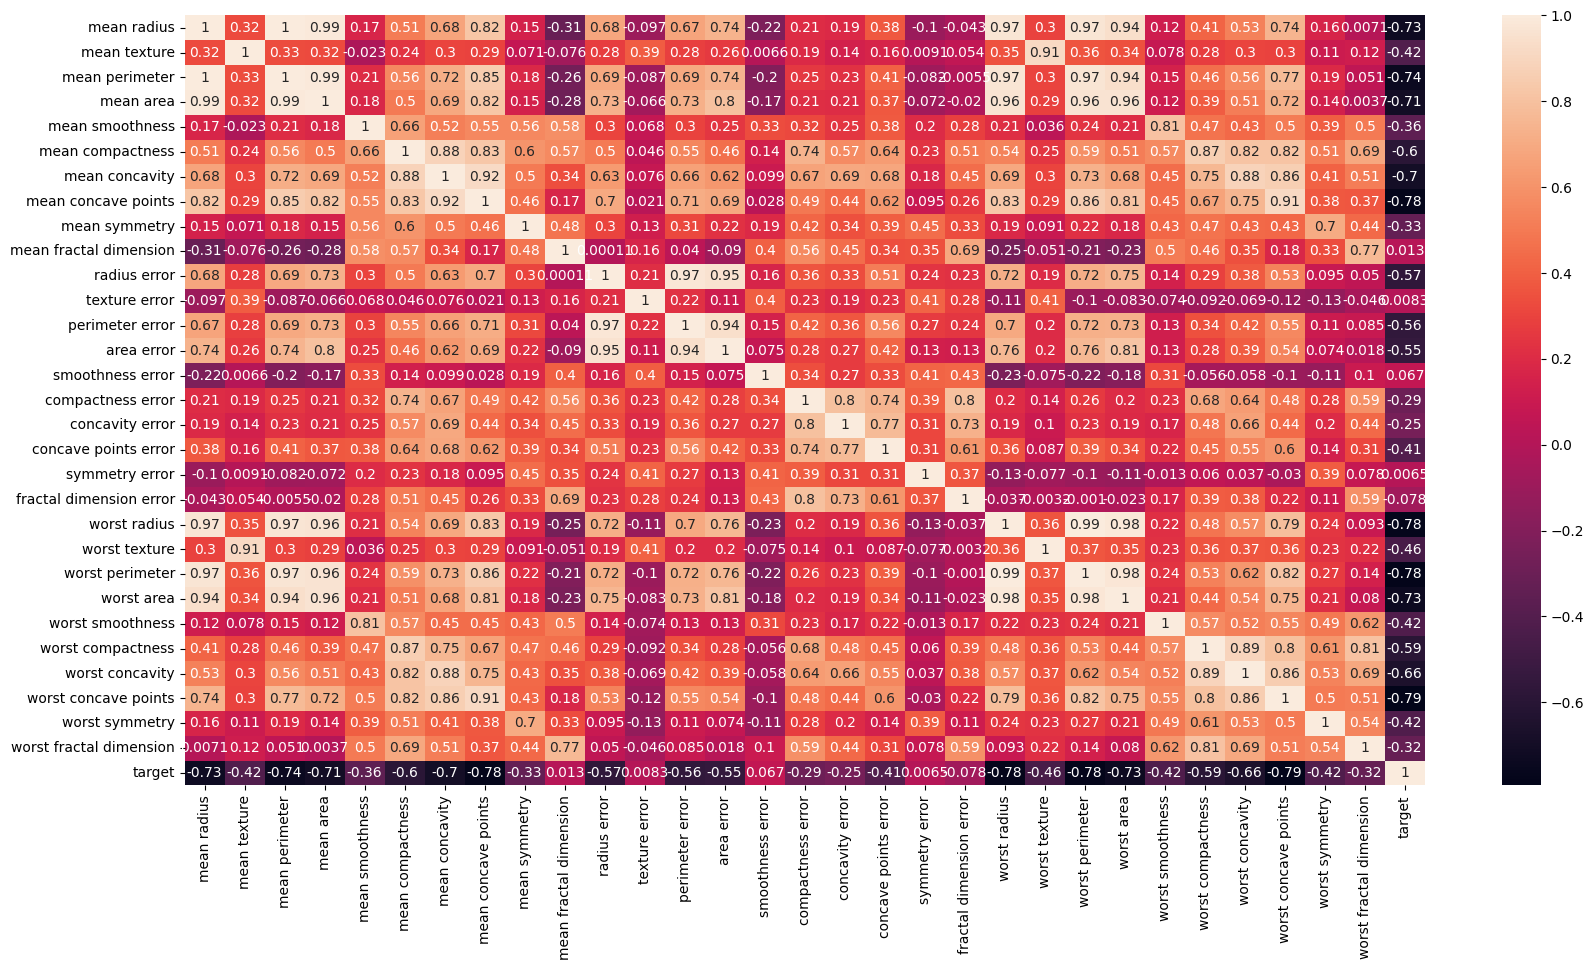

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cancer.corr(), annot=True)

## 3. 학습

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X=df_cancer.drop(['target'], axis=1)
y=df_cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc_model=SVC()
svc_model.fit(X_train, y_train)

SVC()

<Axes: >

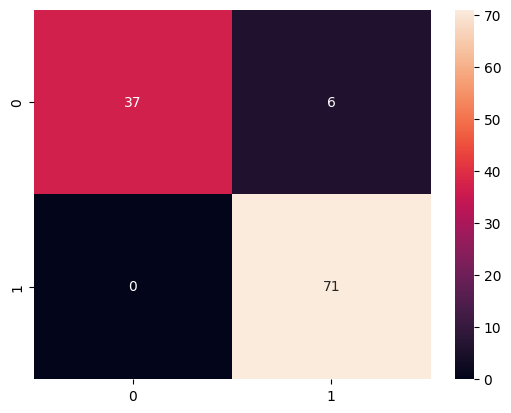

In [15]:
y_predict=svc_model.predict(X_test)
cm=confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

## 4. 모델 개선

<Axes: >

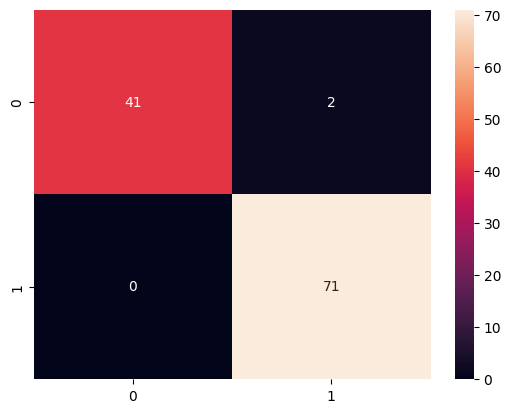

In [16]:
# scaling

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

svc_model.fit(X_train_scaled, y_train)
y_predict=svc_model.predict(X_test_scaled)
cm=confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d")

## 문제 3
confusion matrix 개선을 위한 다른 방법을 제시해주세요. 아래에 코드로 작성해주세요.

<Axes: >

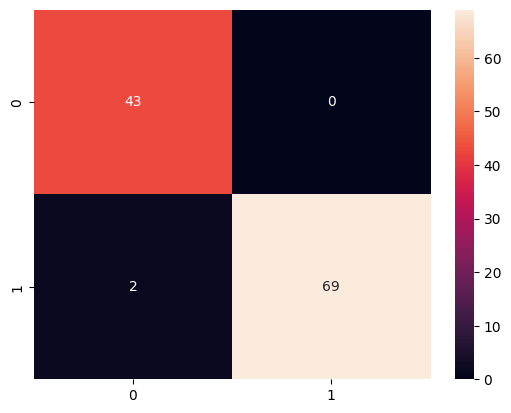

In [ ]:
# 이상치 탐지 및 제거, 특성 선택과 클래스 가중치의 균형 조정을 통해 confusion matrix를 개선할 수 있다.
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import LocalOutlierFactor

# LOF 적용한 이상치 탐지
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_preds = lof.fit_predict(X_train_scaled)

# 이상치 제거
mask = outlier_preds == 1
X_train_filtered = X_train_scaled[mask]
y_train_filtered = y_train[mask]

# 특성 선택
k = 15  
selector = SelectKBest(f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_filtered, y_train_filtered)
X_test_selected = selector.transform(X_test_scaled)

# 클래스 가중치 균형 조정
svc_model = SVC(probability=True, class_weight='balanced')
svc_model.fit(X_train_selected, y_train_filtered)
y_predict = svc_model.predict(X_test_selected)

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d")